In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.special import gammaln
import numpy as np
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from childes_mi.information_theory.emi._nij_op_cython import nij_op_cython


In [4]:
from sklearn.metrics.cluster._expected_mutual_info_fast import expected_mutual_information
expected_mutual_information

<function sklearn.metrics.cluster._expected_mutual_info_fast.expected_mutual_information>

In [5]:
from sklearn.metrics import cluster

In [6]:
import numpy as np
import scipy.sparse
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import adjusted_mutual_info_score

In [35]:
seed = 42
k = 10
n_samples = 10000
random_labels = np.random.RandomState(seed).randint
distribution_a = random_labels(low=0, high=k, size=n_samples)
distribution_b = random_labels(low=0, high=k, size=n_samples)
distribution_b[distribution_b > 5] = 5
C = contingency_matrix(distribution_a, distribution_b, sparse=True)
n_samples = C.sum()
C.shape, n_samples

((10, 6), 10000)

In [117]:
def emi_parallel(contingency, n_samples, use_cython = False, n_jobs=-1, prefer=None):
    """
    EMI without pregenerating lookup table for reduced memory
    https://github.com/clajusch/ClEvaR/blob/master/R/Calculations.R
    """
    
    print("EMI reduced memory parallel")
    s1 = np.array(np.sum(contingency, axis=1, dtype="int").flatten()).flatten()
    s2 = np.array(np.sum(contingency, axis=0, dtype="int").flatten()).flatten()
    N = n_samples
    l1 = len(s1)
    l2 = len(s2)

    nijs = np.arange(0, max(np.max(s1), np.max(s2)) + 1, dtype="float")
    nijs[0] = 1
    term1 = nijs / N
    
    log_Nnij = np.log(N * nijs)
    gln_a = gammaln(s1 + 1)
    gln_b = gammaln(s2 + 1)
    gln_Na = gammaln(N - s1 + 1)
    gln_Nb = gammaln(N - s2 + 1)
    gln_N = gammaln(N + 1)
    gln_nij = gammaln(nijs + 1)
    
    if use_cython:
        nij_func = nij_op_cython
    else:
        nij_func = nij_op

    with Parallel(n_jobs=n_jobs, verbose=0, prefer=prefer) as parallel:
    
        emi = parallel(
            delayed(nij_func)(s1[i], s2, l2, N, term1, nijs, i, gln_a, gln_b, gln_Na, gln_Nb, gln_N, gln_nij, log_Nnij)
            for i in tqdm(range(l1), desc="compute emi", mininterval=0.25)
        )
            

    return np.sum(emi)

In [84]:
"""def nij_op(s1i, s2, l2, N, term1, nijs, i, gln_a, gln_b, gln_Na, gln_Nb, gln_N, gln_nij, log_Nnij):
    emif = 0
    for j in range(l2):
        s2j = s2[j]
        min_nij = np.max([1, s1i - N + s2j])
        max_nij = np.min([s1i, s2j]) + 1
        nij = np.arange(min_nij, max_nij).astype('int')
        t1 = term1[nij]
        t2 = log_Nnij[nij] - np.log(s1i * s2j)

        gln = (
            gln_a[i] + 
            gln_b[j] + 
            gln_Na[i] + 
            gln_Nb[j] - 
            gln_N - 
            gln_nij[nij] - 
            gammaln(s1i - nij + 1) - 
            gammaln(s2j - nij + 1) -
            gammaln(N - s1i- s2j + nij + 1)
        )

        t3 = np.exp(gln)
        emi = sum(t1 * t2 * t3)
        emif += emi
    return emif"""

"def nij_op(s1i, s2, l2, N, term1, nijs, i, gln_a, gln_b, gln_Na, gln_Nb, gln_N, gln_nij, log_Nnij):\n    emif = 0\n    for j in range(l2):\n        s2j = s2[j]\n        min_nij = np.max([1, s1i - N + s2j])\n        max_nij = np.min([s1i, s2j]) + 1\n        nij = np.arange(min_nij, max_nij).astype('int')\n        t1 = term1[nij]\n        t2 = log_Nnij[nij] - np.log(s1i * s2j)\n\n        gln = (\n            gln_a[i] + \n            gln_b[j] + \n            gln_Na[i] + \n            gln_Nb[j] - \n            gln_N - \n            gln_nij[nij] - \n            gammaln(s1i - nij + 1) - \n            gammaln(s2j - nij + 1) -\n            gammaln(N - s1i- s2j + nij + 1)\n        )\n\n        t3 = np.exp(gln)\n        emi = sum(t1 * t2 * t3)\n        emif += emi\n    return emif"

In [120]:
def nij_op(s1i, s2, l2, N, term1, nijs, i, gln_a, gln_b, gln_Na, gln_Nb, gln_N, gln_nij, log_Nnij):
    emif = 0
    for j in range(l2):
        s2j = s2[j]
        min_nij = np.max([1, s1i - N + s2j])
        max_nij = np.min([s1i, s2j]) + 1
        for nij in np.arange(min_nij, max_nij).astype('int'):
            t1 = term1[nij]
            t2 = log_Nnij[nij] - np.log(s1i * s2j)

            gln = (
                gln_a[i] + 
                gln_b[j] + 
                gln_Na[i] + 
                gln_Nb[j] - 
                gln_N - 
                gln_nij[nij] - 
                gammaln(s1i - nij + 1) - 
                gammaln(s2j - nij + 1) -
                gammaln(N - s1i - s2j + nij + 1)
            )

            t3 = np.exp(gln)
            emi = (t1 * t2 * t3)
            emif += emi
    return emif

In [97]:
# 0.002254254559813846
emi_parallel(C, n_samples)

EMI reduced memory parallel


-1185.3862854570461

In [40]:
expected_mutual_information(C, n_samples)

0.002254254559830314

In [41]:
# 2.07
C = scipy.sparse.load_npz('contingency2.npz')
n_samples = C.sum()
n_samples, C.shape

(1317.0, (197, 197))

In [42]:
expected_mutual_information(C, n_samples)

2.0723450591692703

In [43]:
emi_parallel(C, n_samples)

EMI reduced memory parallel


2.0723450591692782

In [44]:
# [01:19<00:00, 67.29it/s] 6.415867094292364
#emi_parallel(C, n_samples)

### test cython

In [45]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [115]:
%%cython -a

from libc.math cimport exp, lgamma
from scipy.special import gammaln
import numpy as np
cimport numpy as np
cimport cython


np.import_array()
ctypedef np.float64_t DOUBLE

def nij_op_cython(int s1i, np.ndarray s2, int l2, int N, np.ndarray term1, 
                  np.ndarray nijs, int i, np.ndarray gln_a, np.ndarray gln_b, 
                  np.ndarray gln_Na, np.ndarray gln_Nb, float gln_N, np.ndarray gln_nij,
                  np.ndarray log_Nnij ######### create ###########
                 ):
    cdef DOUBLE emi, log_aibj, term3, gln, term2
    cdef int min_nij, max_nij, s2j
    emi = 0
    cdef Py_ssize_t j, nij
    for j in range(l2):
        s2j = s2[j]
        min_nij = max([1, s1i + s2j - N])
        max_nij = min([s1i, s2j]) + 1
        
        log_aibj = np.log(s1i * s2j)
        for nij in range(min_nij, max_nij):
            term2 = log_Nnij[nij] - log_aibj
             
            gln = (
                    gln_a[i]
                    + gln_b[j]
                    + gln_Na[i]
                    + gln_Nb[j]
                    - gln_N
                    - gln_nij[nij]
                    - lgamma(s1i - nij + 1)
                    - lgamma(s2j - nij + 1)
                    - lgamma(N - s1i - s2j + nij + 1)
            )
               
            term3 = exp(gln)
            
            emi += (term1[nij] * term2 * term3)
        
    return emi

In [69]:
seed = 42
k = 10
n_samples = 10000
random_labels = np.random.RandomState(seed).randint
distribution_a = random_labels(low=0, high=k, size=n_samples)
distribution_b = random_labels(low=0, high=k, size=n_samples)
distribution_b[distribution_b > 5] = 5
C = contingency_matrix(distribution_a, distribution_b, sparse=True)
n_samples = C.sum()
C.shape, n_samples

((10, 6), 10000)

In [70]:
emi_parallel(C, n_samples, use_cython = True, n_jobs=1)

EMI reduced memory parallel


1.6419384161929018e-44

In [71]:
emi_parallel(C, n_samples, use_cython = True, n_jobs=2, prefer='threads')

EMI reduced memory parallel


1.6419384161929018e-44

In [103]:
# 2.07
C = scipy.sparse.load_npz('contingency2.npz')
n_samples = C.sum()
n_samples, C.shape

(1317.0, (197, 197))

In [121]:
emi_parallel(C, n_samples, use_cython = False, n_jobs=1)

EMI reduced memory parallel


2.0723450591692782

In [118]:
emi_parallel(C, n_samples, use_cython = True, n_jobs=1, prefer=None)

EMI reduced memory parallel


2.072784077767847

In [122]:
C = scipy.sparse.load_npz('test.npz')
n_samples = C.sum()
n_samples, C.shape

(14975, (5372, 5361))

In [123]:
#import pyximport
#pyximport.install()

In [124]:
from joblib import parallel_backend

In [125]:
%time
# ~2 seconds
with parallel_backend('multiprocessing'):
    emi = emi_parallel(C, n_samples, use_cython = True, n_jobs=-1, prefer='processes') # threads processes
print(emi)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs
EMI reduced memory parallel


6.3929520752918645


In [126]:
# ~1 minute
with parallel_backend('loky'):
    emi_parallel(C, n_samples, use_cython = False, n_jobs=-1, prefer=None) # threads processes

EMI reduced memory parallel


KeyboardInterrupt: 

In [ ]:
# ~21 minutes
#with parallel_backend('loky'):
#    emi_parallel(C, n_samples, use_cython = False, n_jobs=1, prefer=None) # threads processes

In [128]:
# ~1 minutes
with parallel_backend('loky'):
    emi_parallel(C, n_samples, use_cython = True, n_jobs=1, prefer=None) # threads processes

EMI reduced memory parallel


KeyboardInterrupt: 

In [129]:
from dask.distributed import Client

In [130]:
client = Client(processes=True) 

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [131]:
import joblib
import IPython

In [132]:
ipythoncachedir = IPython.paths.get_ipython_cache_dir()

In [133]:
def init_pyx(dask_worker):
    import pyximport
    pyximport.install()

    import sys
    sys.path.insert(0,'{}/cython/'.format(ipythoncachedir))   # <<< replace <IPYTHONCACHEDIR> as appropriate

    import remoteCython

client.register_worker_callbacks(init_pyx)

{'tcp://127.0.0.1:34621': {'status': 'OK'},
 'tcp://127.0.0.1:35985': {'status': 'OK'},
 'tcp://127.0.0.1:38884': {'status': 'OK'},
 'tcp://127.0.0.1:40387': {'status': 'OK'},
 'tcp://127.0.0.1:40859': {'status': 'OK'},
 'tcp://127.0.0.1:43736': {'status': 'OK'}}

In [135]:
with joblib.parallel_backend('dask'):
    emi_parallel(C, n_samples, use_cython = True, n_jobs=-1, prefer=None) # threads processes

EMI reduced memory parallel


In [31]:
from childes_mi.information_theory.emi._nij_op_cython import nij_op_cython

In [32]:
%%cython -a

# cython: cdivision=True
# cython: boundscheck=False
# cython: wraparound=False
#
# Authors: Robert Layton <robertlayton@gmail.com>
#           Corey Lynch <coreylynch9@gmail.com>
# License: BSD 3 clause

from libc.math cimport exp, lgamma
from scipy.special import gammaln
import numpy as np
cimport numpy as np
cimport cython

np.import_array()
ctypedef np.float64_t DOUBLE


def expected_mutual_information(contingency, int n_samples):
    """Calculate the expected mutual information for two labelings."""
    cdef int R, C, a_i, b_j, min_nij, max_nij
    cdef DOUBLE N, gln_N, emi, term2, gln
    cdef np.ndarray[DOUBLE] gln_a, gln_b, gln_Na, gln_Nb, gln_nij, log_Nnij
    cdef np.ndarray[DOUBLE] nijs, term1, 
    cdef np.ndarray[np.int32_t] a, b, nija
    
    
    R, C = contingency.shape
    N = <DOUBLE>n_samples
    a = np.ravel(contingency.sum(axis=1).astype(np.int32, copy=False))
    b = np.ravel(contingency.sum(axis=0).astype(np.int32, copy=False))
    
    # There are three major terms to the EMI equation, which are multiplied to
    # and then summed over varying nij values.
    # While nijs[0] will never be used, having it simplifies the indexing.
    nijs = np.arange(0, max(np.max(a), np.max(b)) + 1, dtype='float')
    nijs[0] = 1  # Stops divide by zero warnings. As its not used, no issue.
    
    # term1 is nij / N
    term1 = nijs / N

    # term2 uses N * nij
    log_Nnij = np.log(N * nijs)
    
    # term3 is large, and involved many factorials. Calculate these in log
    # space to stop overflows.
    gln_a = gammaln(a + 1)
    gln_b = gammaln(b + 1)
    gln_Na = gammaln(N - a + 1)
    gln_Nb = gammaln(N - b + 1)
    gln_N = gammaln(N + 1)
    gln_nij = gammaln(nijs + 1)
    
    
    # emi itself is a summation over the various values.
    emi = 0
    cdef Py_ssize_t i, j
    for i in range(R):
        a_i = a[i]
        for j in range(C):
            b_j = b[j]
            
            min_nij = int(np.max([1, a_i - N + b_j]))
            max_nij = int(np.min([a_i, b_j]) + 1)
            
            log_aibj = np.log(a_i * b_j)
            for nij in range(min_nij, max_nij):
                term2 = log_Nnij[nij] - log_aibj

                gln = (
                        gln_a[i]
                        + gln_b[j]
                        + gln_Na[i]
                        + gln_Nb[j]
                        - gln_N
                        - gln_nij[nij]
                        - lgamma(a_i - nij + 1)
                        - lgamma(b_j - nij + 1)
                        - lgamma(N - a_i - b_j + nij + 1)
                )

                term3 = exp(gln)
                emi += (term1[nij] * term2 * term3)
            
    return emi

In [33]:
seed = 42
k = 1000
n_samples = 100000
random_labels = np.random.RandomState(seed).randint
distribution_a = random_labels(low=0, high=k, size=n_samples)
distribution_b = random_labels(low=0, high=k, size=n_samples)
distribution_b[distribution_b > 5] = 5
C = contingency_matrix(distribution_a, distribution_b, sparse=True)
n_samples = C.sum()
C.shape, n_samples

((1000, 6), 100000)

In [35]:
%time
expected_mutual_information(C, n_samples)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs


0.011742939010050328

In [4]:
import scipy.sparse

In [5]:
# 2.07
C = scipy.sparse.load_npz('contingency2.npz')
n_samples = C.sum()
n_samples, C.shape

(1317.0, (197, 197))

In [38]:
expected_mutual_information(C, n_samples)

2.0723450591692703

In [40]:
expected_mutual_information(C, n_samples)

2.0723450591692703

In [41]:
emi_parallel(C, n_samples, use_cython = True, n_jobs=1)

EMI reduced memory parallel


1.6403770527251087

In [10]:
test = C.toarray()

In [14]:
import matplotlib.pyplot as plt
import numpy as np

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


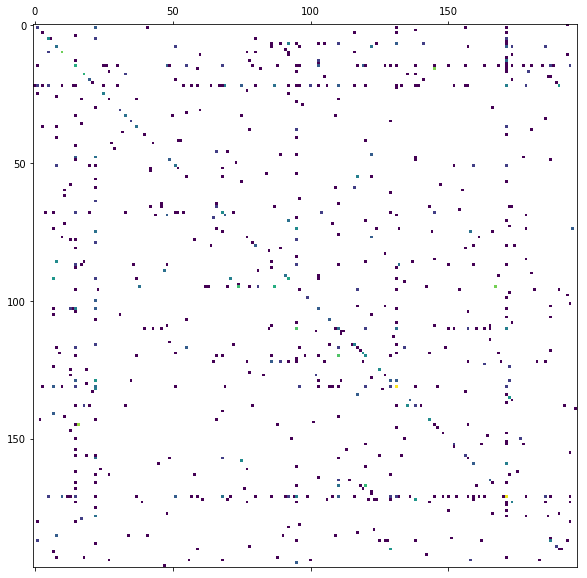

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(np.log(test))